# **E-Commerce Return Prediction**

In [2]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Online Retail.xlsx")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [19]:
# Check if user places more than one order in a day
# hour_check = df.groupby(["CustomerID", df["InvoiceDate"].dt.date])["Invoicehour"].nunique().reset_index()
# hour_check["Invoicehour"].value_counts()

In [6]:
# Check if Invoice no has one to one mapping with the customerID
cust_check = df.groupby(["InvoiceNo"])["CustomerID"].nunique().reset_index()
cust_check["CustomerID"].value_counts()

,count
CustomerID,
1,22190
0,3710


In [28]:
df.isna().sum()

def preprocess(df):
  # # dropping null values
  print("Before dropping null values:", df.shape)
  df.dropna(inplace=True)
  print("After dropping null values:", df.shape)

  print(df.shape)
  df = df[(df["UnitPrice"]>0) & (df["Quantity"]>0)]
  print("After removing negative order:", df.shape)

  df["OrderValue"] = df["UnitPrice"] * df["Quantity"]
  sorted_df = df.sort_values(by=['CustomerID', 'InvoiceDate'])
  # Group and rank: For each customer, count the number of purchases till the previous transaction
  df['PreviousPurchaseCount'] = df.groupby('CustomerID').cumcount()

  cust_seg = df.groupby(["CustomerID"]).agg({"Quantity": "sum", "InvoiceNo": "count", "OrderValue": "mean", "PreviousPurchaseCount": "sum"}).reset_index()
  cust_seg.rename(columns={"InvoiceNo": "TotalOrders"}, inplace=True)
  cust_seg = cust_seg.merge(df[["CustomerID", "Country"]].drop_duplicates(), on="CustomerID", how="left")
  return cust_seg

df1 = preprocess(df)
print(df1.shape)
df1.head()

Before dropping null values: (406829, 8)
After dropping null values: (406829, 8)
(406829, 8)
After removing negative order: (397884, 8)


<ipython-input-28-17eddf5759b6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OrderValue"] = df["UnitPrice"] * df["Quantity"]
<ipython-input-28-17eddf5759b6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PreviousPurchaseCount'] = df.groupby('CustomerID').cumcount()


(4346, 6)


,CustomerID,Quantity,TotalOrders,OrderValue,PreviousPurchaseCount,Country
0,12346.0,74215,1,77183.600000,0,United Kingdom
1,12347.0,2458,182,23.681319,16471,Iceland
2,12348.0,2341,31,57.975484,465,Finland
3,12349.0,631,73,24.076027,2628,Italy
4,12350.0,197,17,19.670588,136,Norway


count    4346.000000
mean       91.760930
std       228.596592
min         1.000000
25%        17.000000
50%        41.000000
75%       100.000000
max      7847.000000
Name: TotalOrders, dtype: float64


<Axes: ylabel='TotalOrders'>

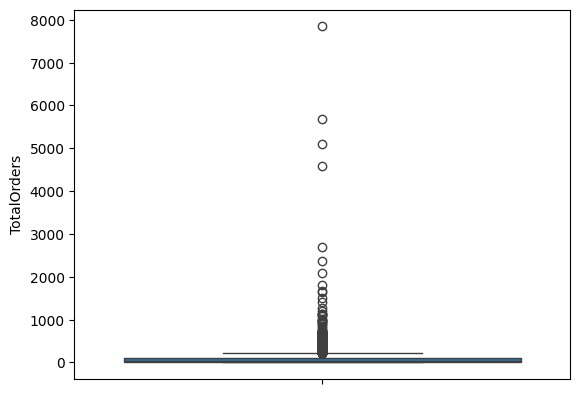

In [29]:
# df1["TotalOrders"].describe() # bin TotalOrder 1-20, 20-40, 40-100, >100
print(df1["TotalOrders"].describe())
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(df1["TotalOrders"])

count     4346.000000
mean        68.279857
std       1466.567890
min          2.101286
25%         12.371283
50%         17.754167
75%         24.919049
max      77183.600000
Name: OrderValue, dtype: float64


<Axes: ylabel='OrderValue'>

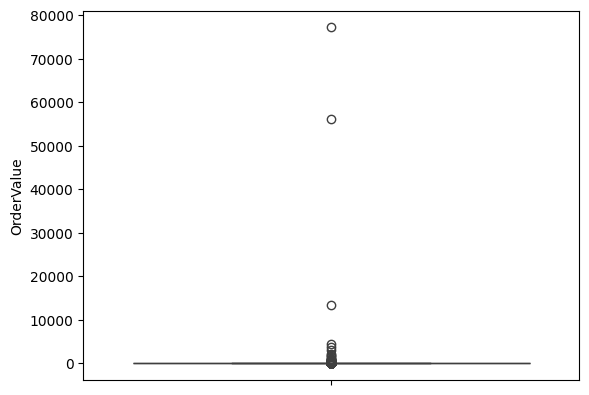

In [30]:
print(df1["OrderValue"].describe())
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(df1["OrderValue"])

count    4.346000e+03
mean     3.028634e+04
std      5.929495e+05
min      0.000000e+00
25%      1.360000e+02
50%      8.200000e+02
75%      4.950000e+03
max      3.078378e+07
Name: PreviousPurchaseCount, dtype: float64


<Axes: ylabel='PreviousPurchaseCount'>

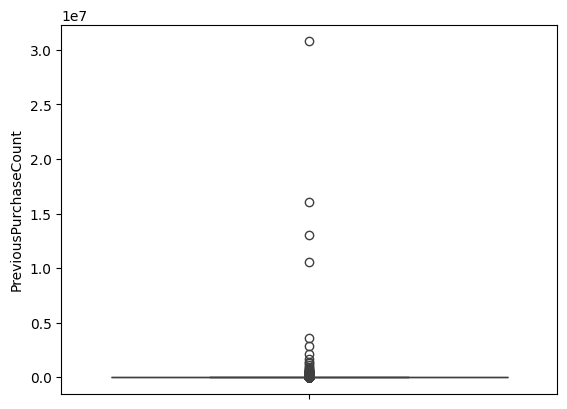

In [31]:
print(df1["PreviousPurchaseCount"].describe())
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(df1["PreviousPurchaseCount"])

<Axes: >

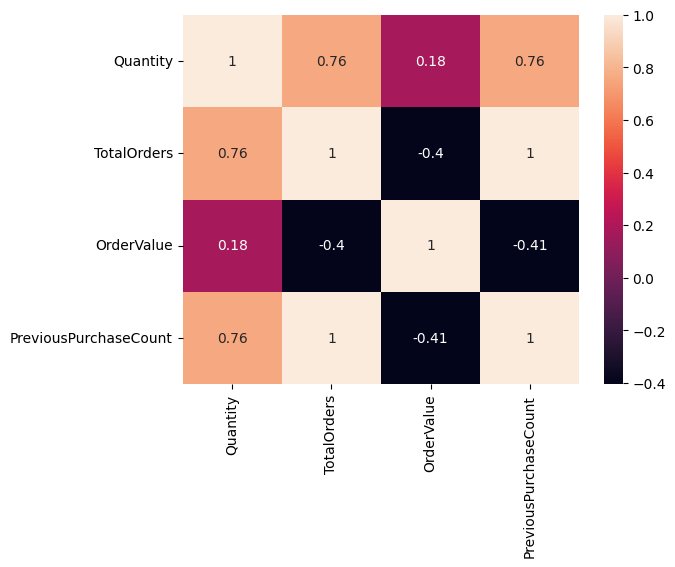

In [43]:
# Feature engineering
# df1.head()
import numpy as np
def feature_engineering(df2):
  # apply log transformation to remove skeyness
  df2['Quantity'] = np.log1p(df2['Quantity'])
  df2['TotalOrders'] = np.log1p(df2['TotalOrders'])
  df2["OrderValue"] = np.log1p(df2['OrderValue'])
  df2["PreviousPurchaseCount"] = np.log1p(df2["PreviousPurchaseCount"])
  return df2

df2 = feature_engineering(df1.copy())
df2 = df2.drop(["Country", "CustomerID"], axis=1)
sns.heatmap(df2.corr(), annot=True)

In [44]:
df2.head()

,Quantity,TotalOrders,OrderValue,PreviousPurchaseCount
0,11.214735,0.693147,11.253955,0.000000
1,7.807510,5.209486,3.206047,9.709417
2,7.758761,3.465736,4.077122,6.144186
3,6.448889,4.304065,3.221912,7.874359
4,5.288267,2.890372,3.028712,4.919981


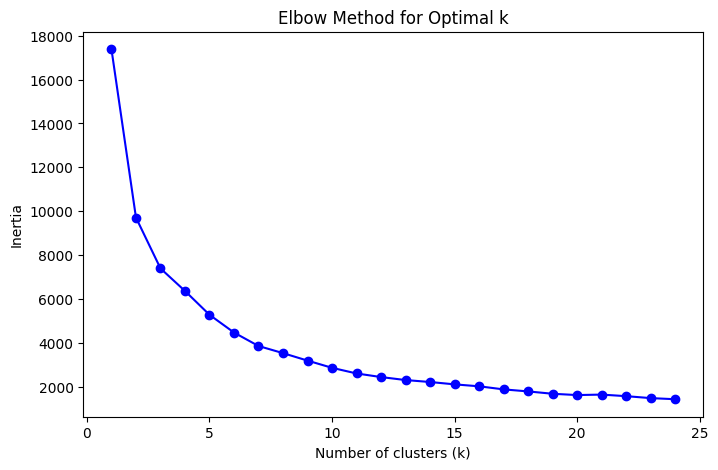

In [49]:
# Modelling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

K = range(1, 25)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df2)

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

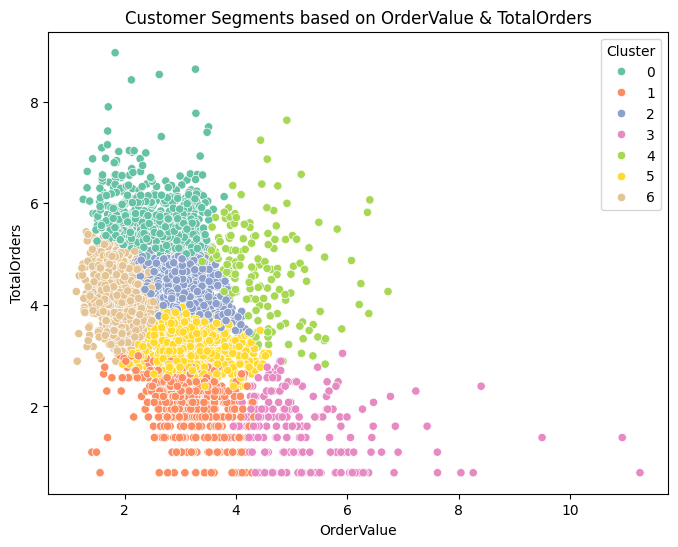

In [53]:
# Train KMeans
kmeans = KMeans(n_clusters=7, random_state=42)
df2['Cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=df2['OrderValue'],
    y=df2['TotalOrders'],
    hue=df2['Cluster'],
    palette='Set2'
)
plt.title('Customer Segments based on OrderValue & TotalOrders')
plt.show()

In [54]:
# calculate silhoutte score

silhouette_avg = silhouette_score(scaled_features, df2['Cluster'])
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.3309711837444278
